## Import Libraries Modules

In [2]:
import sys
parentdir = '/Users/jerzykaminski/Documents/GitHub/BAMT-old'
sys.path.insert(0, parentdir)


In [5]:
sys.path.append('/Users/jerzykaminski/Documents/GitHub/BAMT-old/bayesian')

In [9]:
import time
from tqdm.notebook import tqdm
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from bayesian.train_bn import structure_learning
from graph.precision_recall import precision_recall
from preprocess.discretization import discretization, get_nodes_type, code_categories
from visualization.visualization import draw_BN, draw_comparative_hist
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression

mpl.style.use('seaborn')
plt.rcParams.update({'font.size': 22})


## Functions to calculate possible edges

In [3]:
def get_n_nearest(data, columns, corr=False, number_close=5):
    """Returns n nearest neighbors for every column of dataframe, added into list

    Args:
        data (DataFrame): Proximity matrix
        columns (list): df.columns.tolist()
        corr (bool, optional): _description_. Defaults to False.
        number_close (int, optional): Number of nearest neighbors. Defaults to 5.

    Returns:
        groups
    """
    groups = []
    if corr:
        for c in columns:
            close_ind = data[c].sort_values(ascending=False).index.tolist()
            groups.append(close_ind[0:number_close+1])
    else:
        for c in columns:
            close_ind = data[c].sort_values().index.tolist()
            groups.append(close_ind[0:number_close+1])

    return groups


def get_proximity_matrix(df, df_coded, proximity_metric):
    """Returns matrix of mutual information score of the dataframe, dataframe must be coded first if it contains categorical data

    Args:
        df (DataFrame): data
        df_coded (DataFrame): same data, but coded
        proximity_metric (str): 'MI' or 'corr'

    Returns:
        df_distance: mutual information matrix
    """

    df_distance = pd.DataFrame(data=np.zeros(
        (len(df.columns), len(df.columns))), columns=df.columns)
    df_distance.index = df.columns

    if proximity_metric == 'MI':
        for c1 in df.columns:
            for c2 in df.columns:
                dist = mutual_info_score(
                    df_coded[c1].values, df_coded[c2].values)
                df_distance.loc[c1, c2] = dist

    elif proximity_metric == 'corr':
        df_distance = df_coded.corr(method='pearson')

    return df_distance


def get_brave_matrix(df, proximity_matrix, n_nearest=5):
    """Returns matrix Brave coeffitients of the DataFrame, requires proximity measure to be calculated

    Args:
        df (DataFrame): data
        proximity_matrix (DataFrame): might be generated by get_mutual_info_score_matrix() function or correlation from scipy
        n_nearest (int, optional): _description_. Defaults to 5.

    Returns:
        brave_matrix: DataFrame of Brave coefficients
    """

    brave_matrix = pd.DataFrame(data=np.zeros(
        (len(df.columns), len(df.columns))), columns=df.columns)
    brave_matrix.index = df.columns

    groups = get_n_nearest(proximity_matrix, df.columns.tolist(),
                           corr=True, number_close=n_nearest)

    for c1 in df.columns:
        for c2 in df.columns:
            a = .0
            b = .0
            c = .0
            d = .0
            if c1 != c2:
                for g in groups:
                    if (c1 in g) & (c2 in g):
                        a += 1
                    if (c1 in g) & (c2 not in g):
                        b += 1
                    if (c1 not in g) & (c2 in g):
                        c += 1
                    if (c1 not in g) & (c2 not in g):
                        d += 1
                br = (a * len(groups) + (a + c)*(a + b)) / ((math.sqrt((a + c) *
                                                                       (b + d))) * (math.sqrt((a + b) * (c + d))))
                brave_matrix.loc[c1, c2] = br

    return brave_matrix


def get_possible_edges_by_brave(df, proximity_matrix, n_nearest=5, custom_threshold=False, threshold=.0):
    """Returns list of possible edges for structure learning

    Args:
        df (DataFrame): data
        proximity_matrix (DataFrame): might be generated by get_mutual_info_score_matrix() function, correlation etc.
        n_nearest (int, optional): Number of Nearest neighbors, hyperparameter. Defaults to 5.
        custom_threshold (bool, optional): Must be set true to redact threshold, then set threshold. Defaults to False.
        threshold (float, optional): Threshold for edge candidates to be passed to possible edges, threshold. Defaults to 0.3 [0;1].

    Returns:
        Possible edges: list of possible edges
    """
    brave_matrix = get_brave_matrix(df, proximity_matrix, n_nearest)

    possible_edges = []

    if custom_threshold == False:
        for c1 in df.columns:
            for c2 in df.columns:
                if brave_matrix.loc[c1, c2] > brave_matrix.max(numeric_only='true').max()*0.3:
                    possible_edges.append((c1, c2))
    else:
        for c1 in df.columns:
            for c2 in df.columns:
                if brave_matrix.loc[c1, c2] > brave_matrix.max(numeric_only='true').max()*threshold:
                    possible_edges.append((c1, c2))

    return possible_edges


## Import data, code categorical data

In [4]:
df = pd.read_csv('data/medicine.csv')
df

,total_bilirubin_mean,triglycerides_mean,creatinine_mean,potassium_mean,AST_mean,ALT_mean,sodium_mean,total_protein_mean,HDL_mean,hba1c_mean,...,diabetic_angiopathy,diabetic_nephropathy,neuropathy,cushing_syndrome,stroke,insulins,all_gipoglemic_drugs,all_statins,diuretic,beta_block
0,11.738543,0.670000,137.00,4.500000,28.000000,28.000000,140.000000,67.200000,0.950000,8.667665,...,1,1,1,0,0,1,0,1,1,1
1,27.585625,1.720000,86.00,4.586997,25.500000,29.300000,140.393094,71.245188,1.250000,8.066571,...,0,0,0,0,0,0,0,1,0,1
2,25.028889,1.965000,86.00,4.412873,23.550000,31.650000,140.322773,71.333872,1.400000,7.934365,...,0,0,0,0,0,0,0,1,1,1
3,24.283750,1.806667,91.00,4.384852,21.066667,30.300000,140.850019,70.453878,1.330000,6.106401,...,0,0,0,0,0,0,0,1,1,1
4,24.173043,1.406667,96.00,4.507934,18.850000,30.800000,140.989590,69.446380,1.383333,6.106401,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,5.700000,0.760000,66.00,4.720000,11.600000,14.400000,142.000000,78.400000,1.280000,8.106455,...,1,0,0,0,0,0,1,1,0,0
876,6.800000,2.040000,81.00,5.290000,26.787070,31.472158,143.000000,73.600000,1.220000,10.806466,...,1,1,1,0,1,1,1,0,1,1
877,6.800000,2.040000,81.50,5.350000,27.158420,29.483380,144.500000,73.600000,1.220000,10.806466,...,1,1,1,0,1,1,1,0,1,1
878,5.220000,1.760000,80.50,5.350000,21.200000,24.700000,144.500000,75.105000,1.303333,10.381475,...,1,1,1,0,1,1,1,1,1,1


In [5]:
get_nodes_type(df)


{'total_bilirubin_mean': 'cont',
 'triglycerides_mean': 'cont',
 'creatinine_mean': 'cont',
 'potassium_mean': 'cont',
 'AST_mean': 'cont',
 'ALT_mean': 'cont',
 'sodium_mean': 'cont',
 'total_protein_mean': 'cont',
 'HDL_mean': 'cont',
 'hba1c_mean': 'cont',
 'LDL_mean': 'cont',
 'cholesterol_mean': 'cont',
 'AC_mean': 'cont',
 'hemoglobin_mean': 'cont',
 'hematocrit_mean': 'cont',
 'leukocytes_mean': 'cont',
 'CAD_mean': 'cont',
 'DAD_mean': 'cont',
 'bmi_mean': 'cont',
 'arterial_hypertension': 'disc',
 'essential_hypertension': 'disc',
 'CHF': 'disc',
 'COPD': 'disc',
 'atherosclerosis': 'disc',
 'anemia': 'disc',
 'APC': 'disc',
 'CKD': 'disc',
 'harmful_lifestyle': 'disc',
 'AF': 'disc',
 'IGT': 'disc',
 'metabolic_syndrome': 'disc',
 'obesity': 'disc',
 'stenocardia': 'disc',
 'sleep_disorders': 'disc',
 'DLM': 'disc',
 'hyperglycemia': 'disc',
 'diabetic_osteoarthropathy': 'disc',
 'diabetic_ulcer': 'disc',
 'thyrotoxicosis': 'disc',
 'hypocorticism': 'disc',
 'acromegaly': 'di

In [145]:
# df_coded, coder = code_categories(df, 'label', ['Treatment'])
# df_coded


,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
0,15,-0.024292,-0.586966,-0.899764,0.033749,0.103225,-0.086061,0.017900,-0.169745,0.063473,0.002719,0.063663,0.012567,0.125654,0.183070
1,3,0.050041,-0.183173,-0.060256,0.392190,0.265600,0.161536,0.209129,0.037667,-0.292480,0.091249,0.048620,0.117321,-0.250286,-0.066847
2,13,0.290626,1.102717,1.119642,0.121322,0.024326,0.150335,0.085781,0.185094,0.005325,-0.276571,-0.023624,-0.011758,0.064647,0.367146
3,7,-0.093101,-0.598244,-0.576037,-0.051983,-0.125209,0.043662,0.088573,0.045876,-0.096188,-0.164706,0.040966,0.016691,0.249739,-0.192147
4,11,0.036238,-0.282622,-0.527552,-0.286420,-0.032482,-0.157269,-0.041638,-0.403866,-0.039083,0.036017,-0.019958,0.015746,0.107479,0.155337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,-0.402468,-0.605394,-1.177523,-0.929616,-0.111477,-0.074208,-0.270649,-0.104261,0.310882,-0.159241,0.008462,-0.079647,0.592347,0.514770
9996,7,-0.309361,-0.861410,-0.614646,-0.356151,-0.164184,0.004549,-0.153423,0.069357,-0.187956,-0.122543,-0.030264,-0.015067,-0.483274,-0.731731
9997,1,-0.014488,-0.181456,0.577202,1.113623,0.162742,0.080877,0.088615,0.219562,-0.251131,0.012876,-0.028722,0.041994,-0.480069,-0.560375
9998,11,0.208087,0.379347,0.416380,-0.013353,0.079704,0.016461,0.070865,0.158818,-0.071004,-0.048707,0.006313,-0.000960,0.070482,0.065929


In [6]:
structure_right = pd.read_csv(
    'data/medicine_true.csv')
sparsebn_edges = pd.read_csv(
    'data/magic-niab_sparsebn.csv')
bidag_edges = pd.read_csv(
    'data/medicine_discrete_bidag.csv')

print(structure_right, sparsebn_edges, bidag_edges)


                       V1                    V2
0          thyrotoxicosis  total_bilirubin_mean
1             all_statins  total_bilirubin_mean
2             all_statins    triglycerides_mean
3             all_statins              ALT_mean
4             all_statins              AST_mean
..                    ...                   ...
135         hyperglycemia  diabetic_nephropathy
136         hyperglycemia            neuropathy
137  diabetic_nephropathy    total_protein_mean
138  diabetic_nephropathy                   CKD
139                   CKD    total_protein_mean

[140 rows x 2 columns]           V1        V2
0   YR.GLASS  YR.FIELD
1   YR.GLASS       MIL
2   YR.GLASS      G418
3   YR.GLASS      G311
4   YR.GLASS     G1217
..       ...       ...
65     G1800     G2835
66       FUS     G1896
67     G1750  YR.GLASS
68      G524       MIL
69      G775        FT

[70 rows x 2 columns]                        V1                     V2
0    total_bilirubin_mean         potassium_mean
1  

## Experiments

Calculate SHD score of baselines

In [10]:
pr_sparsebn = precision_recall(sparsebn_edges, structure_right)['SHD']
pr_bidag = precision_recall(bidag_edges, structure_right)['SHD']

print(pr_sparsebn, pr_bidag)


206 343


In [29]:
range_of_n_nearest = np.arange(3, 10)
time_of_experiment = []
brave_shd = []
df_discrete, _ = discretization(df, 'equal_frequency', ['total_bilirubin_mean',
                                                                  'triglycerides_mean',
                                                                  'creatinine_mean',
                                                                  'potassium_mean',
                                                                  'AST_mean',
                                                                  'ALT_mean',
                                                                  'sodium_mean',
                                                                  'total_protein_mean',
                                                                  'HDL_mean',
                                                                  'hba1c_mean',
                                                                  'LDL_mean',
                                                                  'cholesterol_mean',
                                                                  'AC_mean',
                                                                  'hemoglobin_mean',
                                                                  'hematocrit_mean',
                                                                  'leukocytes_mean',
                                                                  'CAD_mean',
                                                                  'DAD_mean',
                                                                  'bmi_mean'])
    
df_discrete.to_csv('data/medicine_discrete.csv')

for i in tqdm(range_of_n_nearest):
    start_time = time.time()
    df_mis = get_proximity_matrix(
        df_discrete, df_discrete, proximity_metric='MI')
    possible_edges = get_possible_edges_by_brave(
        df_discrete, proximity_matrix=df_mis, n_nearest=i)
    bn = structure_learning(df_discrete, 'HC', get_nodes_type(
        df_discrete), 'K2', white_list=possible_edges)
    brave_edges = []
    for e in bn['E']:
        brave_edges.append((e[0], e[1]))
    time_of_experiment.append(time.time() - start_time)
    pr_brave = precision_recall(brave_edges, structure_right)['SHD']
    brave_shd.append(pr_brave)


  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
brave_edges

[('total_bilirubin_mean', 'creatinine_mean'),
 ('total_bilirubin_mean', 'AST_mean'),
 ('total_bilirubin_mean', 'hba1c_mean'),
 ('triglycerides_mean', 'AC_mean'),
 ('triglycerides_mean', 'total_bilirubin_mean'),
 ('triglycerides_mean', 'hba1c_mean'),
 ('triglycerides_mean', 'leukocytes_mean'),
 ('triglycerides_mean', 'sodium_mean'),
 ('triglycerides_mean', 'AST_mean'),
 ('creatinine_mean', 'CKD'),
 ('creatinine_mean', 'diabetic_ulcer'),
 ('creatinine_mean', 'leukocytes_mean'),
 ('creatinine_mean', 'atherosclerosis'),
 ('creatinine_mean', 'diabetic_angiopathy'),
 ('creatinine_mean', 'COPD'),
 ('creatinine_mean', 'stenocardia'),
 ('creatinine_mean', 'AST_mean'),
 ('potassium_mean', 'creatinine_mean'),
 ('potassium_mean', 'sodium_mean'),
 ('potassium_mean', 'AST_mean'),
 ('AST_mean', 'ALT_mean'),
 ('total_protein_mean', 'creatinine_mean'),
 ('total_protein_mean', 'beta_block'),
 ('HDL_mean', 'total_protein_mean'),
 ('HDL_mean', 'leukocytes_mean'),
 ('HDL_mean', 'potassium_mean'),
 ('hba1c_

In [22]:
time_of_experiment

[8.54961633682251,
 10.54498553276062,
 7.596424102783203,
 14.367341995239258,
 38.86224842071533,
 27.99208402633667,
 15.316105127334595]

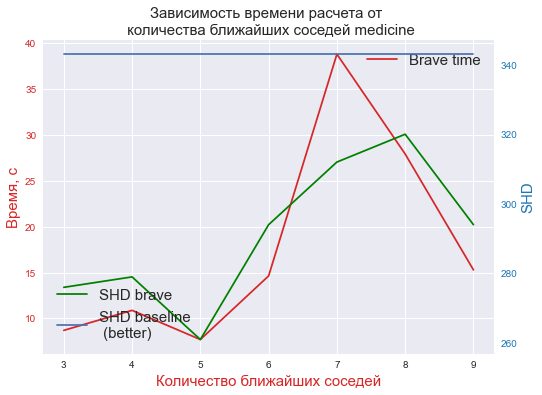

In [30]:
baseline_shd = [min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(
    pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag)]


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Количество ближайших соседей', fontsize=15, color=color)
ax1.set_ylabel('Время, с', color=color, fontsize=15)
ax1.plot(range_of_n_nearest, time_of_experiment,
         color=color, label='Brave time')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(fontsize=15)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('SHD', color=color, fontsize=15)
ax2.plot(range_of_n_nearest, brave_shd, color='g', label='SHD brave')
ax2.plot(range_of_n_nearest, baseline_shd, label='SHD baseline \n (better)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(fontsize=15, loc = 'lower left')

fig.tight_layout()
plt.grid(False)
plt.title('Зависимость времени расчета от \n количества ближайших соседей medicine', fontsize=15)
plt.show()


In [25]:
time_of_experiment = []
brave_shd = []

df_discrete, _ = discretization(df, 'equal_frequency', ['total_bilirubin_mean',
                                                                  'triglycerides_mean',
                                                                  'creatinine_mean',
                                                                  'potassium_mean',
                                                                  'AST_mean',
                                                                  'ALT_mean',
                                                                  'sodium_mean',
                                                                  'total_protein_mean',
                                                                  'HDL_mean',
                                                                  'hba1c_mean',
                                                                  'LDL_mean',
                                                                  'cholesterol_mean',
                                                                  'AC_mean',
                                                                  'hemoglobin_mean',
                                                                  'hematocrit_mean',
                                                                  'leukocytes_mean',
                                                                  'CAD_mean',
                                                                  'DAD_mean',
                                                                  'bmi_mean'])
df_mis = get_proximity_matrix(df, df_discrete, proximity_metric='MI')
range_of_threshholds = np.arange(0.3, 0.8, 0.05)


for i in tqdm(range_of_threshholds):
    start_time = time.time()
    possible_edges = get_possible_edges_by_brave(
        df_discrete, proximity_matrix=df_mis, custom_threshold=True, threshold=i)
    bn = structure_learning(df_discrete, 'HC', get_nodes_type(
        df_discrete), 'K2', white_list=possible_edges)
    brave_edges = []
    for e in bn['E']:
        brave_edges.append((e[0], e[1]))
    time_of_experiment.append(time.time() - start_time)
    pr_brave = precision_recall(brave_edges, structure_right)['SHD']
    brave_shd.append(pr_brave)


  0%|          | 0/10 [00:00<?, ?it/s]

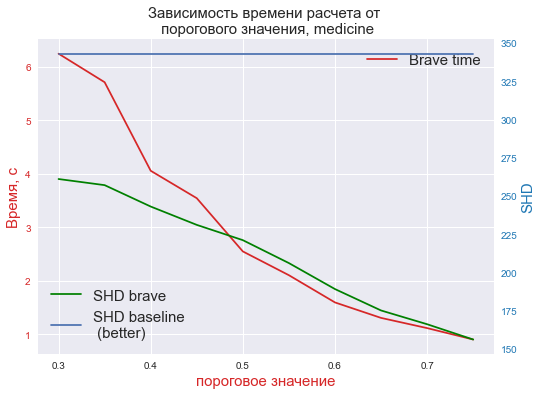

In [27]:
baseline_shd = [min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(
    pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag), min(pr_sparsebn, pr_bidag)]


fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('пороговое значение', fontsize=15, color=color)
ax1.set_ylabel('Время, с', color=color, fontsize=15)
ax1.plot(range_of_threshholds, time_of_experiment,
         color=color, label='Brave time')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(fontsize=15)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('SHD', color=color, fontsize=15)
ax2.plot(range_of_threshholds, brave_shd, color='g', label='SHD brave')
ax2.plot(range_of_threshholds, baseline_shd, label='SHD baseline \n (better)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(fontsize=15, loc='lower left')

fig.tight_layout()
plt.grid(False)
plt.title(
    'Зависимость времени расчета от \n порогового значения, medicine', fontsize=15)
plt.show()


In [68]:
df = pd.read_csv('data/pigs.csv')

In [ ]:
for i in tqdm(experiment_range):
    start_time = time.time()
    df_loop = df.sample(n=i, axis='columns')
    df_mis = get_mutual_info_score_matrix(df_loop, df_loop, continuous=False)
    possible_edges = get_possible_edges_by_brave(df_loop, proximity_matrix=df_mis)
    bn = structure_learning(df_loop, 'HC', get_nodes_type(
        df_loop), 'K2', white_list=possible_edges)
    brave_edges = []
    for e in bn['E']:
            brave_edges.append((e[0], e[1]))
    time_of_experiment.append(time.time() - start_time)

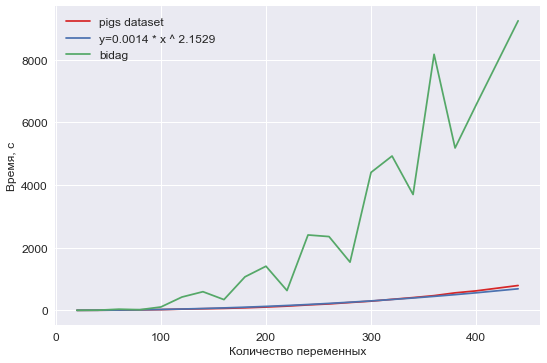

In [ ]:
brave_time = [1.521608, 4.30287, 36.94609, 20.49653, 107.5941, 424.94136, 594.9396, 343.15086, 1069.3152, 1408.1304, 632.2404, 2405.3274, 2354.1102, 1538.4378, 4401.6984, 4924.4436, 3696.9624, 8169.4764, 5181.6456, 6553.476, 9239.5368]
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Количество переменных', fontsize = 12)
ax1.set_ylabel('Время, с', fontsize = 12)
ax1.plot(experiment_range, time_of_experiment, color=color, label = 'pigs dataset')
ax1.plot(experiment_range, 0.0014 * np.power(experiment_range, 2.1529), label = 'y=0.0014 * x ^ 2.1529')
ax1.plot(experiment_range, brave_time, label = 'bidag')

ax1.legend(fontsize = 12)

#ax2 = ax1.twinx()

#color = 'tab:blue'
#ax2.set_ylabel('Время, с', color=color)
#ax2.plot(range_of_n_nearest, time_n_nearest, color=color)
#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.xticks(rotation='horizontal', fontsize = 12)
plt.yticks(rotation='horizontal', fontsize = 12)
plt.show()